<a href="https://colab.research.google.com/github/nklsKrmnn/LSC_Sentiment_Analysis/blob/main/Projekt_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
#from google.colab import drive
#drive.mount('/content/drive')

In [12]:
!jt -l

Der Befehl "jt" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [13]:
!jt -r

Der Befehl "jt" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


# 0. Imports

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import warnings

warnings.filterwarnings("ignore")


# 1. Dataset: Movie Reviews

In [15]:
dataset_mr = pd.read_csv("../data/train.tsv", sep='\t')


In [16]:
dataset_mr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [17]:
dataset_mr.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [18]:
pd.set_option('display.max_colwidth', None)
dataset_mr.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what is good for the goose,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is good for the goose,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for the goose,2


<Axes: xlabel='Sentiment', ylabel='count'>

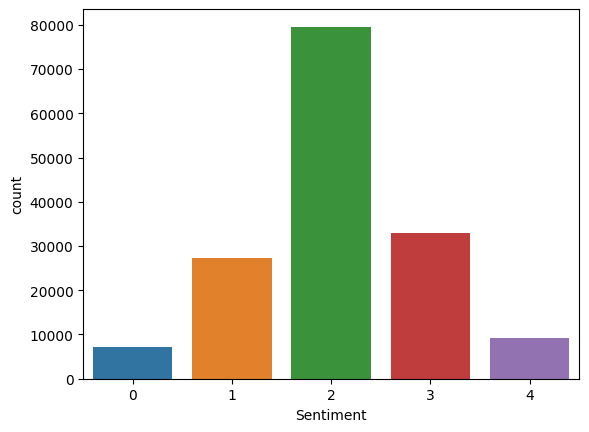

In [19]:
sns.countplot(x='Sentiment', data=dataset_mr)
# TODO: Beschriftungen & Schlussfolgerung

In [20]:
dataset_mr_full_senences = dataset_mr.groupby('SentenceId').first().reset_index()
dataset_mr_full_senences.head(5)

,SentenceId,PhraseId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,64,"This quiet , introspective and entertaining independent is worth seeking .",4
2,3,82,"Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .",1
3,4,117,"A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .",3
4,5,157,Aggressive self-glorification and a manipulative whitewash .,1


<Axes: xlabel='Sentiment', ylabel='count'>

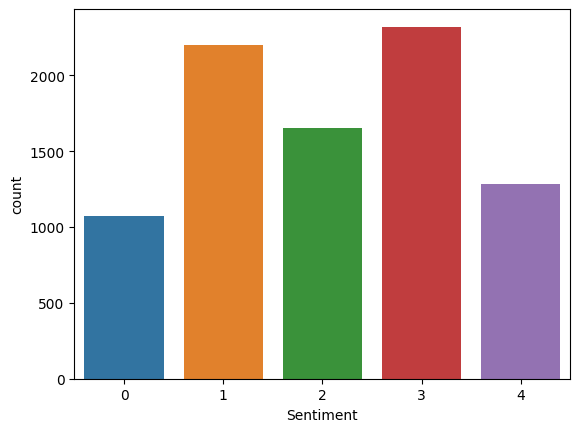

In [21]:
sns.countplot(x='Sentiment', data=dataset_mr_full_senences)
# --> besser

In [22]:
value_mapping = {0: -1, 1: -1, 2: 0, 3: 1, 4: 1}
dataset_mr_relabled = dataset_mr_full_senences
dataset_mr_relabled['Sentiment'] = dataset_mr_relabled['Sentiment'].map(value_mapping)
dataset_mr_relabled.head()

,SentenceId,PhraseId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",-1
1,2,64,"This quiet , introspective and entertaining independent is worth seeking .",1
2,3,82,"Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .",-1
3,4,117,"A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .",1
4,5,157,Aggressive self-glorification and a manipulative whitewash .,-1


In [23]:
def dataset_split(dataset: pd.DataFrame, n: int):
    """
    Funktion, um ein dataset in mehrere gleichgroße Datasets zu splitte
    :param dataset: dataset, das gesplittet werden soll
    :param n: Anzahl der Subset, in die gesplittet werden soll
    :return: Subsets
    """
    set_size = dataset.shape[0]/n
    subsets = []
    for _ in range(8):
        subsets.append(dataset.loc[_*set_size:(_+1)*set_size, :])
    return subsets


In [24]:
def balancing(dataset: pd.DataFrame, column_label: str):
    """
    Funktion um einen Datensatz nach enthaltenen Labels zu balancen.
    :param dataset: Dataset, das balanced werden soll.
    :param column_label: Spalte in der sich die Labels befinden.
    :return: Balanced dataset
    """
    balanced_set = dataset
    sentiment_groups = dataset[column_label].value_counts()
    max_size = sentiment_groups.max()

    for i in sentiment_groups.index.values:
        ratio = int(max_size / sentiment_groups[i])
        
        for j in range(int(ratio)+1):
            current_size = balanced_set[column_label].value_counts()[i]
            n = min([(max_size-current_size), sentiment_groups[i]])
            balanced_set = pd.concat([balanced_set, dataset.loc[dataset[column_label] == i].sample(n=n)])
    
    return balanced_set.sample(frac=1)

In [25]:
def save_dataset(dataset, name, path):
    """
    Speichert ein pandas DataFrame als csv
    :param dataset: pandas DataFrame
    :param name: Name des csv-files
    :param path: Pfand zum Ordner, wo das csv-file gespeichert werden soll
    :return: None
    """
    file_path = path + "/"+ name
    dataset.to_csv(path_or_buf=file_path, sep=";")

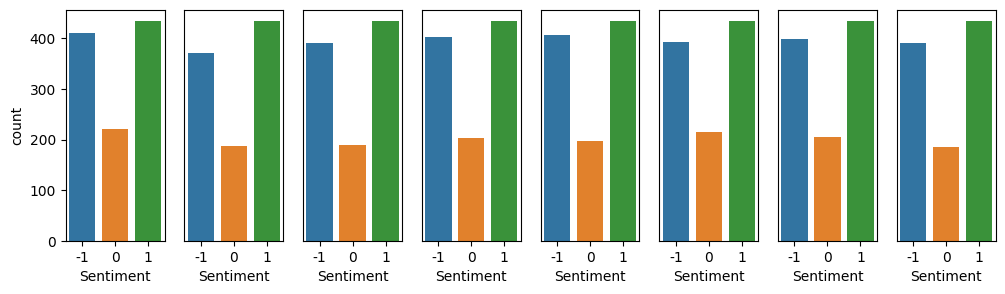

In [26]:
subsets = dataset_split(dataset_mr_relabled, 8)

fig, axes = plt.subplots(1, len(subsets), figsize=(12,3))
for _, ax in enumerate(axes):
    sns.countplot(x='Sentiment', data=subsets[_], ax=ax)
    if (_ > 0):
        ax.get_yaxis().set_visible(False)

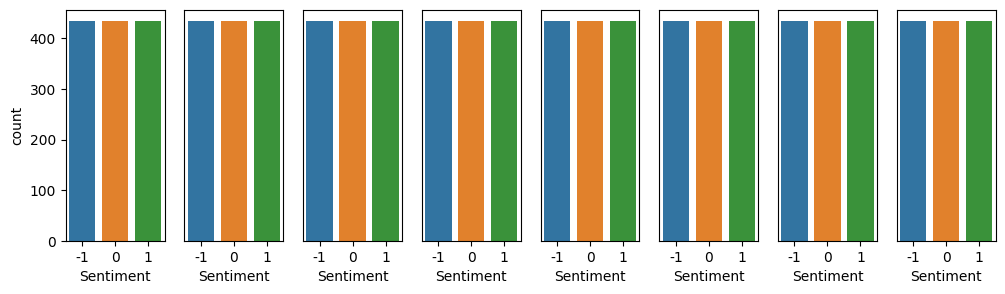

In [27]:
for i in range(len(subsets)):
    subsets[i] = balancing(subsets[i], "Sentiment")
    
fig, axes = plt.subplots(1, len(subsets), figsize=(12,3))
for _, ax in enumerate(axes):
    sns.countplot(x='Sentiment', data=subsets[_], ax=ax)
    if (_ > 0):
        ax.get_yaxis().set_visible(False)

In [28]:
# Zusammenfügen gesamttrainingsset
trainset_complete = pd.concat(subsets[:6])

dir_path = "../data/datasets_mr"

save_dataset(subsets[0], "Trainset_1.csv", dir_path)
save_dataset(subsets[1], "Trainset_2.csv", dir_path)
save_dataset(subsets[2], "Trainset_3.csv", dir_path)
save_dataset(subsets[3], "Trainset_4.csv", dir_path)
save_dataset(subsets[4], "Trainset_5.csv", dir_path)
save_dataset(subsets[5], "Trainset_6.csv", dir_path)
save_dataset(trainset_complete, "Trainset_complete.csv", dir_path)
save_dataset(subsets[6], "Evaluationset.csv", dir_path)
save_dataset(subsets[7], "Testset.csv", dir_path)

In [ ]:
# TODO: (Niklas): Amazon dataset https://www.kaggle.com/datasets/751487ccef508fca5ede15ba1cf2b7e44edbc763fb91cb5d26fd6c28ddd87d91

In [ ]:
# TODO: (Eira): Tweets dataset https://www.kaggle.com/datasets/kazanova/sentiment140 (done)

# 1. Dataset: Tweets

In [29]:
import sklearn
import pandas as pd
import seaborn as sns

In [30]:
with open("../data/tweets.csv") as csvdatei:
    dataset_tw = pd.read_csv(csvdatei, delimiter=',')

In [31]:
dataset_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

In [32]:
dataset_tw.describe()

,0,1467810369
count,1.599999e+06,1.599999e+06
mean,2.000001e+00,1.998818e+09
std,2.000001e+00,1.935757e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.956916e+09
50%,4.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [33]:
pd.set_option('display.max_colwidth', None)
dataset_tw.head(10)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing


In [34]:
# Cleaning: nicht benötigte Spalten löschen, Spalten umbenennen

dataset_tw.columns = ['Sentiment','ID','date','flag','user','Phrase']
dataset_tw.drop(['date','flag','user'], axis=1, inplace=True)
dataset_tw = sklearn.utils.shuffle(dataset_tw)

dataset_tw.head(10)


,Sentiment,ID,Phrase
876995,4,1684875297,talking to my bestedt friend on the world then off to sleep
875675,4,1680814063,Work....eh :/ guess i should be happy to go since im so friggen broke....come eat and tip me reallll well. Lol
1578300,4,2189796217,http://twitpic.com/7j4bi - good follower
671392,0,2246850031,"having a great morning so far- woke up with a sore neck, burnt my breakfast, broke one of mums fav photo frames and cut my leg shaving"
1576230,4,2189510671,Seven pounds!!
1433213,4,2060402702,Have no worries. The Penguins are about to have a third period like no other.
422952,0,2062767536,"@nekonoai not sure why...it's on T*pepad and so i have little control over how things work, unlike my other sites"
1145987,4,1977864684,"driving around with brad, vernon, vinny, and phoebe. typical saturday night."
1215483,4,1989543760,"today looks like it's going to be release day, just need to scan the cover art. stay tuned"
978515,4,1833841292,this is what always happened.... u n me.. laughing and wasting time.. love u my best friend for all my life


<Axes: xlabel='Sentiment', ylabel='count'>

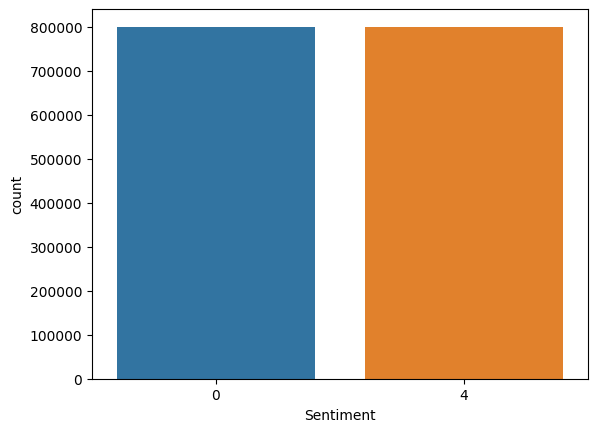

In [35]:
import seaborn as sns
sns.countplot(x='Sentiment', data=dataset_tw)
# TODO: Beschriftungen & Schlussfolgerung

In [56]:
def dataset_split(dataset: pd.DataFrame, n: int):
    """
    Funktion, um ein dataset in mehrere gleichgroße Datasets zu splitte
    :param dataset: dataset, das gesplittet werden soll
    :param n: Anzahl der Subset, in die gesplittet werden soll
    :return: Subsets
    """
    set_size = dataset.shape[0]/n
    subsets = []
    for _ in range(n):
        subsets.append(dataset.loc[_*set_size:(_+1)*set_size, :])
    return subsets

In [57]:
def save_dataset(dataset, name, path):
    """
    Speichert ein pandas DataFrame als csv
    :param dataset: pandas DataFrame
    :param name: Name des csv-files
    :param path: Pfand zum Ordner, wo das csv-file gespeichert werden soll
    :return: None
    """
    file_path = path + "/"+ name
    dataset.to_csv(path_or_buf=file_path, sep=";")

In [58]:
subsets_tw = dataset_split(dataset_tw, 8)

fig, axes = plt.subplots(1, len(subsets_tw), figsize=(12,3))
for _, ax in enumerate(axes):
    sns.countplot(x='Sentiment', data=subsets_tw[_], ax=ax)
    if (_ > 0):
        ax.get_yaxis().set_visible(False)

KeyError: 199999.875

In [55]:
# Zusammenfügen gesamttrainingsset
trainset_complete_tw = pd.concat(subsets_tw[:6])

dir_path = "../data/datasets_tw"

save_dataset(subsets_tw[0], "Trainset_1.csv", dir_path)
save_dataset(subsets_tw[1], "Trainset_2.csv", dir_path)
save_dataset(subsets_tw[2], "Trainset_3.csv", dir_path)
save_dataset(subsets_tw[3], "Trainset_4.csv", dir_path)
save_dataset(subsets_tw[4], "Trainset_5.csv", dir_path)
save_dataset(subsets_tw[5], "Trainset_6.csv", dir_path)
save_dataset(trainset_complete_tw, "Trainset_complete.csv", dir_path)
save_dataset(subsets_tw[6], "Evaluationset.csv", dir_path)
save_dataset(subsets_tw[7], "Testset.csv", dir_path)

NameError: name 'subsets_tw' is not defined